In [157]:

import random
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import networkx as nx
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
import hypll.nn as hnn
from hypll.optim import RiemannianSGD

# 1. Load the CIFAR-100 dataset and build a hierarchy
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# cifar100_graph = build_cifar100_hierarchy()
import networkx as nx
from torchvision import datasets

def build_cifar100_hierarchy():
    cifar100 = datasets.CIFAR100(root='./data', train=True, download=True)
    coarse_to_fine = {
        'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
        'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
        'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
        'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
        'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
        'household electrical devices': ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
        'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
        'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
        'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
        'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
        'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
        'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
        'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
        'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
        'people': ['baby', 'boy', 'girl', 'man', 'woman'],
        'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
        'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
        'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
        'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
        'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'],
    }
    fine_labels = {label: i for i, label in enumerate(cifar100.classes)}
    graph = nx.DiGraph()

    coarse_labels = list(coarse_to_fine.keys())
    idx = 0 
    l1, l2 = [], []
    for parent_id, parent_name in enumerate(coarse_labels):
        graph.add_node(idx, name=parent_name)
        #print("Added coarse node:", idx, parent_name)
        parent_id = idx
        l1.append(idx)
        idx += 1
        for child_name in coarse_to_fine[parent_name]:
            if child_name not in fine_labels:
                print(f"Error: '{child_name}' not found in fine_labels")
                continue
            child_id = fine_labels[child_name]
            graph.add_node(idx, name=child_name)
            #print("Added fine node:", idx, child_name)
            graph.add_edge(parent_id, idx)
            l2.append(idx)
            idx += 1
    return graph, l2, l1

cifar100_graph,l_finer_poincare,l_hyper = build_cifar100_hierarchy()

# 2. Create a dataset containing the graph from which we can sample
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

class CIFAR100EmbeddingDataset(Dataset):
    def __init__(self, graph):
        super().__init__()
        self.graph = graph
        self.edges_list = list(graph.edges())

    def __len__(self):
        return len(self.edges_list)

    def __getitem__(self, idx):
        rel = self.edges_list[idx]
        negative_target_nodes = list(
            self.graph.nodes() - nx.descendants(self.graph, rel[0]) - {rel[0]}
        )
        negative_target_sample_size = min(5, len(negative_target_nodes))
        negative_target_nodes_sample = random.sample(
            negative_target_nodes, negative_target_sample_size
        )
        edges = torch.tensor([rel] + [[rel[0], neg] for neg in negative_target_nodes_sample])
        negative_source_nodes = list(
            self.graph.nodes() - nx.ancestors(self.graph, rel[1]) - {rel[1]}
        )
        negative_source_sample_size = 10 - negative_target_sample_size
        negative_source_nodes_sample = random.sample(
            negative_source_nodes, negative_source_sample_size
        )
        edges = torch.cat(
            tensors=(edges, torch.tensor([[neg, rel[1]] for neg in negative_source_nodes_sample])),
            dim=0,
        )
        edge_label_targets = torch.cat(tensors=[torch.ones(1).bool(), torch.zeros(10).bool()])
        return edges, edge_label_targets

dataset = CIFAR100EmbeddingDataset(cifar100_graph)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# 3. Initialize the Poincare ball on which the embeddings will be trained
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

poincare_ball = PoincareBall(Curvature(1.0))

# 4. Define the Poincare embedding model
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

class PoincareEmbedding(hnn.HEmbedding):
    def __init__(self, num_embeddings, embedding_dim, manifold):
        super().__init__(num_embeddings, embedding_dim, manifold)

    def forward(self, edges):
        embeddings = super().forward(edges)
        edge_distances = self.manifold.dist(x=embeddings[:, :, 0, :], y=embeddings[:, :, 1, :])
        return edge_distances

model = PoincareEmbedding(
    num_embeddings=len(cifar100_graph.nodes()),
    embedding_dim=64,
    manifold=poincare_ball,
)#dimension
# 5. Define the Poincare embedding loss function
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

def poincare_embeddings_loss(dists, targets):
    logits = dists.neg().exp()
    numerator = torch.where(condition=targets, input=logits, other=0).sum(dim=-1)
    denominator = logits.sum(dim=-1)
    loss = (numerator / denominator).log().mean().neg()
    return loss
def distortion_loss(embeddings, dist_targets, ball):
    embedding_dists = ball.dist(x=embeddings[:, :, 0, :], y=embeddings[:, :, 1, :])
    losses = (embedding_dists - dist_targets).abs() / dist_targets
    return losses.mean()
# 6. Perform a few "burn-in" training epochs with reduced learning rate
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

optimizer = RiemannianSGD(
    params=model.parameters(),
    lr=0.3 / 10,
)

for epoch in range(10):
    average_loss = 0
    for idx, (edges, edge_label_targets) in enumerate(dataloader):
        optimizer.zero_grad()
        dists = model(edges)
        loss = poincare_embeddings_loss(dists=dists, targets=edge_label_targets)
        loss.backward()
        optimizer.step()
        average_loss += loss

    average_loss /= len(dataloader)
    print(f"Burn-in epoch {epoch} loss: {average_loss}")

optimizer = RiemannianSGD(
    params=model.parameters(),
    lr=0.3,
    #0.3
)


for epoch in range(300):
    average_loss = 0
    for idx, (edges, edge_label_targets) in enumerate(dataloader):
        optimizer.zero_grad()
        dists = model(edges)
        loss = poincare_embeddings_loss(dists=dists, targets=edge_label_targets)
        loss.backward()
        optimizer.step()
        average_loss += loss

    average_loss /= len(dataloader)
    print(f"Epoch {epoch} loss: {average_loss}")

# You have now trained your own Poincare Embeddings on CIFAR-100!

Files already downloaded and verified
Burn-in epoch 0 loss: 2.37829327583313
Burn-in epoch 1 loss: 2.381565570831299
Burn-in epoch 2 loss: 2.3822216987609863
Burn-in epoch 3 loss: 2.3772168159484863
Burn-in epoch 4 loss: 2.379472494125366
Burn-in epoch 5 loss: 2.373506784439087
Burn-in epoch 6 loss: 2.375370979309082
Burn-in epoch 7 loss: 2.372036933898926
Burn-in epoch 8 loss: 2.36619234085083
Burn-in epoch 9 loss: 2.3723483085632324
Epoch 0 loss: 2.3712661266326904
Epoch 1 loss: 2.3564136028289795
Epoch 2 loss: 2.3498032093048096
Epoch 3 loss: 2.337378978729248
Epoch 4 loss: 2.3321309089660645
Epoch 5 loss: 2.3271422386169434
Epoch 6 loss: 2.3136966228485107
Epoch 7 loss: 2.3036444187164307
Epoch 8 loss: 2.3081517219543457
Epoch 9 loss: 2.291715621948242
Epoch 10 loss: 2.3008077144622803
Epoch 11 loss: 2.2861716747283936
Epoch 12 loss: 2.2997798919677734
Epoch 13 loss: 2.2848689556121826
Epoch 14 loss: 2.2750682830810547
Epoch 15 loss: 2.284943103790283
Epoch 16 loss: 2.2842857837677

In [158]:
def build_cifar100_hierarchy_root():
    cifar100 = datasets.CIFAR100(root='./data', train=True, download=True)
    coarse_to_fine = {
        'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
        'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
        'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
        'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
        'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
        'household electrical devices': ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
        'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
        'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
        'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
        'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
        'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
        'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
        'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
        'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
        'people': ['baby', 'boy', 'girl', 'man', 'woman'],
        'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
        'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
        'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
        'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
        'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'],
    }
    fine_labels = {label: i for i, label in enumerate(cifar100.classes)}
    graph = nx.DiGraph()    
    # Add root node
    root_node = 'root'
    root = 120
    graph.add_node(root, label="root")

    coarse_labels = list(coarse_to_fine.keys())
    idx = root -1
    l1, l2 = [], []
    for parent_id, parent_name in enumerate(coarse_labels):
        graph.add_node(idx, label=parent_name)
        graph.add_edge(root, idx)
        parent_id =idx
        #print("Added coarse node:", idx, parent_name)
        l1.append(idx)
        idx -= 1
        for child_name in coarse_to_fine[parent_name]:
            if child_name not in fine_labels:
                print(f"Error: '{child_name}' not found in fine_labels")
                continue
            child_id = fine_labels[child_name]
            graph.add_node(idx, label=child_name)
            #print("Added fine node:", idx, child_name)
            graph.add_edge(parent_id, idx)
            l2.append(idx)
            idx -= 1
    return graph, l2, l1

cifar100_graph, l_finer, l_hyper = build_cifar100_hierarchy_root()

# Print the nodes and edges to verify the hierarchy
print("Nodes:", cifar100_graph.nodes(data=True))
print("Edges:", cifar100_graph.edges(data=True))

Files already downloaded and verified
Nodes: [(120, {'label': 'root'}), (119, {'label': 'aquatic mammals'}), (118, {'label': 'beaver'}), (117, {'label': 'dolphin'}), (116, {'label': 'otter'}), (115, {'label': 'seal'}), (114, {'label': 'whale'}), (113, {'label': 'fish'}), (112, {'label': 'aquarium_fish'}), (111, {'label': 'flatfish'}), (110, {'label': 'ray'}), (109, {'label': 'shark'}), (108, {'label': 'trout'}), (107, {'label': 'flowers'}), (106, {'label': 'orchid'}), (105, {'label': 'poppy'}), (104, {'label': 'rose'}), (103, {'label': 'sunflower'}), (102, {'label': 'tulip'}), (101, {'label': 'food containers'}), (100, {'label': 'bottle'}), (99, {'label': 'bowl'}), (98, {'label': 'can'}), (97, {'label': 'cup'}), (96, {'label': 'plate'}), (95, {'label': 'fruit and vegetables'}), (94, {'label': 'apple'}), (93, {'label': 'mushroom'}), (92, {'label': 'orange'}), (91, {'label': 'pear'}), (90, {'label': 'sweet_pepper'}), (89, {'label': 'household electrical devices'}), (88, {'label': 'clock'

In [137]:
import json
data = nx.node_link_data(cifar100_graph)

# Define the path to the JSON file where you want to save the graph data
file_path = "cifar100.json"

# Save the serialized data to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(data, json_file, indent=4)

print(f"Graph data saved to {file_path}")

Graph data saved to cifar100.json


In [110]:
def load_graph_from_file(file_path: str) -> nx.DiGraph:
    with open(file_path, "r") as json_file:
        graph_dict = json.load(json_file)
    
    graph = nx.node_link_graph(graph_dict)

    return graph

121

In [138]:
model_loaded = torch.load('minimal_working_hec/experiments/embeddings/2024-06-18_12-56-17/DistortionEmbedding_weights_64.pth')
tst = model_loaded["weight"].data.cpu()

In [172]:

#embeddings_poincare = model.weight.data.cpu()
embeddings_dist = model_loaded["weight"].data.cpu()
hyper_embedings = embeddings_dist[l_hyper]
finer_embedings = embeddings_dist[l_finer]


In [170]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from geoopt import ManifoldParameter
from geoopt.manifolds import PoincareBall
#from hypll.manifolds.poincare_ball import Curvature, PoincareBall

# Set random seed for reproducibility
torch.manual_seed(42)

# Load the CIFAR-100 dataset
train_dataset = CIFAR100(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=ToTensor())

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initializing the Poincare Ball with curvature 1.0
#poincare_ball  = PoincareBall(Curvature(1.0))
poincare_ball = PoincareBall(c=1.0)

# Define the model architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 64)  
        self.fc2 = nn.Linear(64, 64)  

        self.ball = poincare_ball
        self.tau = 10

        # Initialize hyper_embedings and finer_embedings
        self.hyperclass_prototypes = hyper_embedings
        self.finer_prototypes = finer_embedings

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor while preserving the batch size
        x_mid = nn.functional.relu(self.fc1(x))
        embeddings = self.fc2(x_mid)  
        embeddings_hyp = self.ball.expmap0(embeddings)  # Project embeddings to the Poincare ball

        hyper_dists = -self.ball.dist(embeddings_hyp.unsqueeze(1), self.hyperclass_prototypes.unsqueeze(0)) * self.tau
        finer_dists = -self.ball.dist(embeddings_hyp.unsqueeze(1), self.finer_prototypes.unsqueeze(0)) * self.tau
        return finer_dists, hyper_dists,embeddings_hyp

# Create an instance of the model
model = CNN()

# Define the loss functions and optimizer
criterion_fine = nn.CrossEntropyLoss()
criterion_hyper = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)

# Train the model
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("training")
for epoch in range(num_epochs):
    model.train()
    print(epoch)
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        hyper_labels = labels // 5  # Convert labels to hyperclass labels (0-19)
        #
        #print(hyper_labels)
        optimizer.zero_grad()
        finer_dists, hyper_dists,embeddings_hyp = model(images)
        # print(finer_dists)
        # print(hyper_dists)
        loss_fine = criterion_fine(finer_dists, labels)
        #print(loss_fine)
        #print(loss_hyper)
        loss_hyper = criterion_hyper(hyper_dists, hyper_labels)  # Use negative distances as logits for loss calculation
        loss = loss_fine + loss_hyper  # Combined loss
        loss.backward()
        optimizer.step()

# Get the model predictions
print("eval")
model.eval()
predictions_fine = []
predictions_hyper = []
true_labels = []
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        targets = targets.to(device)
        hyper_labels = targets // 5  # Convert labels to hyperclass labels (0-19)
        fine_output, hyper_dists,embeddings_hyp = model(images)
        # Select the class with the maximum probability for fine-grained classification
        pred_fine = fine_output.argmax(dim=1)
        # Select the hyperclass with the minimum distance
        pred_hyper = hyper_dists.argmax(dim=1)
        predictions_fine.append(pred_fine.cpu())
        predictions_hyper.append(pred_hyper.cpu())
        true_labels.append(targets.cpu())

predictions_fine = torch.cat(predictions_fine, dim=0)
predictions_hyper = torch.cat(predictions_hyper, dim=0)
true_labels = torch.cat(true_labels, dim=0)

# Calculate accuracy for fine-grained classification
accuracy_fine = (predictions_fine == true_labels).float().mean()
print(f'Fine-grained Classification Accuracy: {accuracy_fine:.4f}')

# Calculate accuracy for hyperclass classification
accuracy_hyper = (predictions_hyper == (true_labels // 5)).float().mean()
print(f'Hyperclass Classification Accuracy: {accuracy_hyper:.4f}')

Files already downloaded and verified
Files already downloaded and verified
training
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
eval
Fine-grained Classification Accuracy: 0.0583
Hyperclass Classification Accuracy: 0.3372


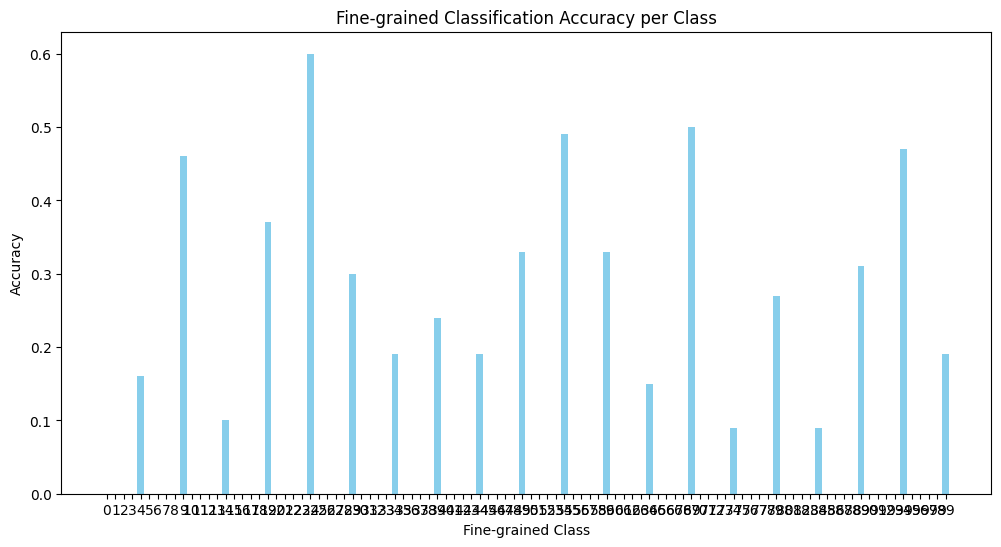

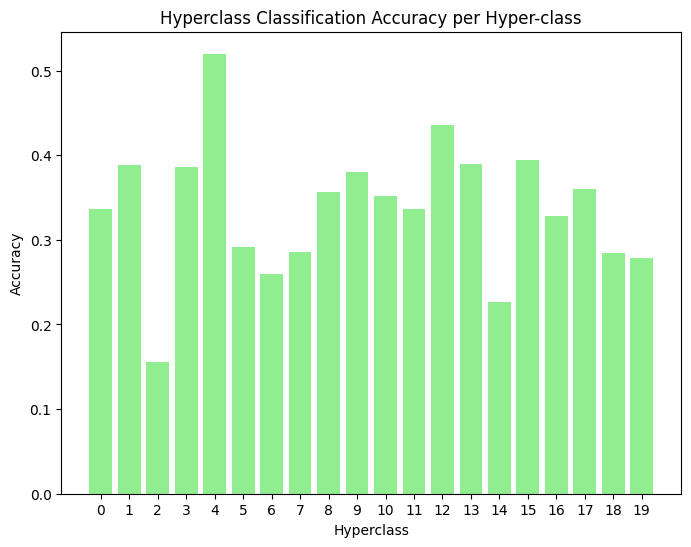

In [175]:
import matplotlib.pyplot as plt
import torch

# Assuming 'predictions_fine', 'predictions_hyper', and 'true_labels' are already defined

# Calculate the fine-grained classification accuracy per class
unique_classes = torch.unique(true_labels)
class_accuracies = {}

for cls in unique_classes:
    class_indices = (true_labels == cls)
    class_accuracy = (predictions_fine[class_indices] == cls).float().mean().item()
    class_accuracies[cls.item()] = class_accuracy

# Calculate the hyperclass classification accuracy per hyper-class
hyperclass_labels = true_labels // 5
unique_hyperclasses = torch.unique(hyperclass_labels)
hyperclass_accuracies = {}

for hcls in unique_hyperclasses:
    hyperclass_indices = (hyperclass_labels == hcls)
    hyperclass_accuracy = (predictions_hyper[hyperclass_indices] == hcls).float().mean().item()
    hyperclass_accuracies[hcls.item()] = hyperclass_accuracy

# Plotting the fine-grained classification accuracy per class
plt.figure(figsize=(12, 6))
plt.bar(class_accuracies.keys(), class_accuracies.values(), color='skyblue')
plt.xlabel('Fine-grained Class')
plt.ylabel('Accuracy')
plt.title('Fine-grained Classification Accuracy per Class')
plt.xticks(range(len(class_accuracies)), labels=class_accuracies.keys())
plt.show()

# Plotting the hyperclass classification accuracy per hyper-class
plt.figure(figsize=(8, 6))
plt.bar(hyperclass_accuracies.keys(), hyperclass_accuracies.values(), color='lightgreen')
plt.xlabel('Hyperclass')
plt.ylabel('Accuracy')
plt.title('Hyperclass Classification Accuracy per Hyper-class')
plt.xticks(range(len(hyperclass_accuracies)), labels=hyperclass_accuracies.keys())
plt.show()

In [174]:
model_hybrid 

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (ball): PoincareBall manifold
)

In [190]:
print("eval")
model.eval()
predictions_fine = []
predictions_hyper = []
true_labels = []
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        targets_fine = targets.to(device)  # Fine-grained targets (0-99)
        targets_hyper = targets // 5  # Convert labels to hyperclass labels (0-19) for evaluation
        outputs,ll,lk = model(images)
        pred_fine = outputs.argmax(dim=1)
        pred_hyper = (pred_fine // 5)  # Convert fine-grained predictions to hyperclass predictions
        predictions_fine.append(pred_fine.cpu())
        predictions_hyper.append(pred_hyper.cpu())
        true_labels.append(targets_fine.cpu())

predictions_fine = torch.cat(predictions_fine, dim=0)
predictions_hyper = torch.cat(predictions_hyper, dim=0)
true_labels = torch.cat(true_labels, dim=0)
true_hyper_labels = true_labels // 5

# Calculate accuracy for fine-grained classification
accuracy_fine = (predictions_fine == true_labels).float().mean()
print(f'Fine-grained Classification Accuracy: {accuracy_fine:.4f}')

# Calculate accuracy for hyperclass classification
accuracy_hyper = (predictions_hyper == true_hyper_labels).float().mean()
print(f'Hyperclass Classification Accuracy: {accuracy_hyper:.4f}')

eval
Fine-grained Classification Accuracy: 0.5965
Hyperclass Classification Accuracy: 0.6125
